Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Using device: cuda
Upload the video


Saving test.mp4 to test.mp4
Video uploaded: test.mp4
Extracted 41 frames


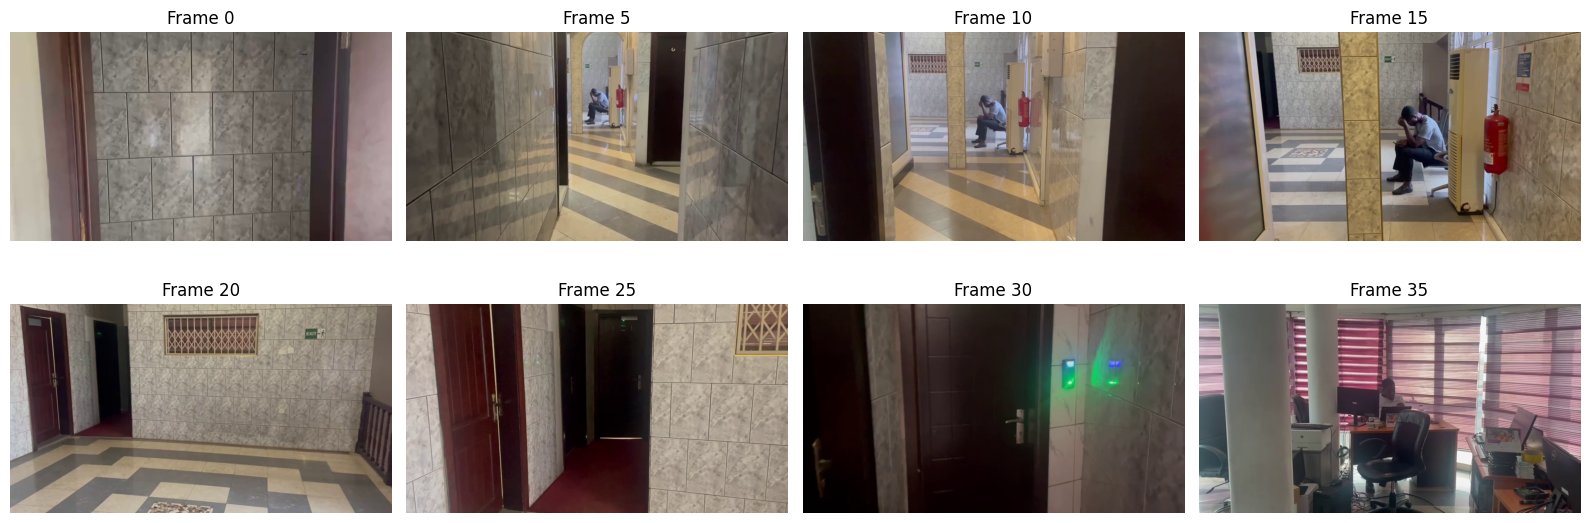

In [2]:
!pip install torch torchvision timm opencv-python matplotlib
!pip install stable-baselines3 gymnasium
!pip install imageio imageio-ffmpeg
!apt-get install -y ffmpeg


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import imageio
import warnings
warnings.filterwarnings('ignore')

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# upload
def upload_video_colab():
    from google.colab import files
    print("Upload the video")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Using demo mode with synthetic data.")
        return None

    video_path = list(uploaded.keys())[0]
    print(f"Video uploaded: {video_path}")
    return video_path

def extract_frames_from_video(video_path, target_frames=40):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video file: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frame_interval = max(1, total_frames // target_frames)

    frames = []
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret: break
        if frame_idx % frame_interval == 0:
            if width > 1280:
                scale = 1280 / width
                frame = cv2.resize(frame, (1280, int(height*scale)))
            frames.append(frame)
        frame_idx += 1
    cap.release()
    print(f"Extracted {len(frames)} frames")
    return frames, fps

def create_demo_office_video():
    frames = []
    for i in range(40):
        img = np.ones((480, 640, 3), dtype=np.uint8) * 240  # Light gray
        cv2.rectangle(img, (0, 300), (640, 480), (200, 200, 200), -1)  # Floor
        cv2.rectangle(img, (0, 0), (100, 480), (150, 150, 150), -1)  # Left wall
        cv2.rectangle(img, (540, 0), (640, 480), (150, 150, 150), -1)  # Right wall

        if i > 20:
            desk_x = 150 + (i - 20) * 5
            cv2.rectangle(img, (desk_x, 200), (desk_x + 80, 280), (139, 69, 19), -1)  # Desk
            cv2.rectangle(img, (desk_x + 100, 220), (desk_x + 150, 290), (100, 100, 200), -1)  # Chair

        noise = np.random.randint(-20, 20, img.shape, dtype=np.int16)
        img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        frames.append(img)
    print(f"Created {len(frames)} demo frames")
    return frames

# Load video
try:
    video_path = upload_video_colab()
    if video_path:
        frames, fps = extract_frames_from_video(video_path, target_frames=40)
    else:
        frames = create_demo_office_video()
        fps = 30.0
except Exception as e:
    print(f"Upload error: {e}")
    frames = create_demo_office_video()
    fps = 30.0

# Visualize sequence
fig, axes = plt.subplots(2, 4, figsize=(16,6))
for i in range(8):
    idx = i * (len(frames)//8)
    row, col = i//4, i%4
    axes[row, col].imshow(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB))
    axes[row, col].set_title(f"Frame {idx}")
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()



In [3]:

# Midas
class MiDaSDepthEstimator:
    def __init__(self, device='cuda', model_type='DPT_Large'):
        self.device = device
        print(f"\n Loading MiDaS depth model ({model_type})...")
        try:
            self.model = torch.hub.load("intel-isl/MiDaS", model_type, pretrained=True).to(device)
            self.model.eval()
            midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
            self.transform = midas_transforms.dpt_transform
            self.use_midas = True
            print("MiDaS loaded successfully!")
        except:
            self.use_midas = False
            self._init_simple_model()

    def _init_simple_model(self):
        class SimpleDepthNet(nn.Module):
            def __init__(self):
                super().__init__()
                self.encoder = nn.Sequential(
                    nn.Conv2d(3, 64, 7, stride=2, padding=3), nn.ReLU(),
                    nn.Conv2d(64, 128, 5, stride=2, padding=2), nn.ReLU(),
                    nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU())
                self.decoder = nn.Sequential(
                    nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(),
                    nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
                    nn.ConvTranspose2d(64,1,4,stride=2,padding=1), nn.Sigmoid())
            def forward(self,x): return self.decoder(self.encoder(x))
        self.model = SimpleDepthNet().to(self.device).eval()
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Resize((256,512)),
                                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

    def estimate_depth(self, image):
        if isinstance(image, np.ndarray):
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image_rgb = np.array(image)
        with torch.no_grad():
            if self.use_midas:
                input_batch = self.transform(image_rgb).to(self.device)
                prediction = self.model(input_batch)
                prediction = F.interpolate(prediction.unsqueeze(1), size=image_rgb.shape[:2], mode="bicubic", align_corners=False).squeeze()
                depth = prediction.cpu().numpy()
                depth = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)
            else:
                img_tensor = self.transform(Image.fromarray(image_rgb)).unsqueeze(0).to(self.device)
                depth = self.model(img_tensor).squeeze().cpu().numpy()
        return depth

depth_estimator = MiDaSDepthEstimator(device=device)
depth_maps = [depth_estimator.estimate_depth(f) for f in frames]

# Occupancy
class SmartOccupancyGridBuilder:
    def __init__(self, grid_size=(30,40), close_threshold=0.65):
        self.grid_size = grid_size
        self.close_threshold = close_threshold

    def depth_to_occupancy(self, depth_map):
        depth_resized = cv2.resize(depth_map, (self.grid_size[1], self.grid_size[0]), interpolation=cv2.INTER_NEAREST)
        occupancy = (depth_resized > self.close_threshold).astype(np.float32)
        floor_region = occupancy[int(self.grid_size[0]*0.7):, :]
        floor_region *= 0.3
        return occupancy

grid_builder = SmartOccupancyGridBuilder(grid_size=(30,40))




 Loading MiDaS depth model (DPT_Large)...
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


100%|██████████| 1.28G/1.28G [00:10<00:00, 133MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


MiDaS loaded successfully!


In [4]:

occupancy_grids = []
for depth in depth_maps:
    occ_grid = grid_builder.depth_to_occupancy(depth)
    occupancy_grids.append(occ_grid)

print(f"Generated {len(occupancy_grids)} occupancy grids")


Generated 41 occupancy grids


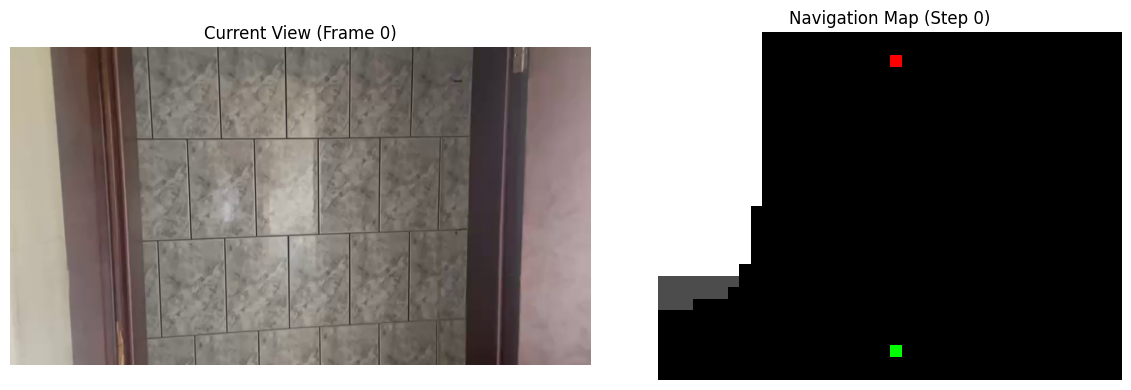

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 150      |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    fps             | 397      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 1024     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 142         |
|    ep_rew_mean          | -1.32       |
| time/                   |             |
|    fps                  | 168         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.012383301 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | -0.000343   |
|    learning_rate        | 0.

Training completed and model saved!


In [5]:
# Navigation
class OfficeNavigationEnv(gym.Env):
    def __init__(self, frames, occupancy_grids, grid_size=(30, 40)):
        super().__init__()
        self.frames = frames
        self.occupancy_grids = occupancy_grids
        self.grid_size = grid_size
        self.max_frames = len(frames)

        # Start and goal positions
        self.start_pos = np.array([grid_size[0] - 3, grid_size[1] // 2])
        self.goal_pos = np.array([2, grid_size[1] // 2])
        self.agent_pos = self.start_pos.copy()

        self.current_frame = 0
        self.max_steps = 150
        self.current_step = 0
        self.trajectory = []

        # Define Gym spaces
        self.action_space = spaces.Discrete(5)  # up, down, left, right, stay
        obs_size = grid_size[0] * grid_size[1] + 3
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(obs_size,), dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = self.start_pos.copy()
        self.current_frame = 0
        self.current_step = 0
        self.trajectory = [self.agent_pos.copy()]
        obs = self._get_obs()
        return obs.astype(np.float32), {}

    def _get_obs(self):
        grid_flat = self.occupancy_grids[self.current_frame].flatten().astype(np.float32)
        pos_norm = (self.agent_pos / np.array(self.grid_size)).astype(np.float32)
        frame_progress = np.array([self.current_frame / self.max_frames], dtype=np.float32)
        obs = np.concatenate([grid_flat, pos_norm, frame_progress])
        return obs.astype(np.float32)

    def step(self, action):
        self.current_step += 1
        old_pos = self.agent_pos.copy()

        # Movement map: up, down, left, right, stay
        move_map = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1), 4: (0, 0)}
        dy, dx = move_map[action]
        self.agent_pos = np.array([
            np.clip(self.agent_pos[0] + dy, 0, self.grid_size[0] - 1),
            np.clip(self.agent_pos[1] + dx, 0, self.grid_size[1] - 1)
        ])

        if action in [0, 1, 2, 3]:
            self.current_frame = min(self.current_frame + 1, self.max_frames - 1)

        self.trajectory.append(self.agent_pos.copy())
        current_grid = self.occupancy_grids[self.current_frame]
        hit_obstacle = current_grid[self.agent_pos[0], self.agent_pos[1]] > 0.5

        # Default small penalty for each step
        reward = -0.1
        terminated = False
        truncated = False

        # Obstacle penalty
        if hit_obstacle:
            reward = -15.0
            terminated = True
        else:
            old_dist = np.linalg.norm(old_pos - self.goal_pos)
            new_dist = np.linalg.norm(self.agent_pos - self.goal_pos)
            reward += (old_dist - new_dist) * 3.0  # progress reward

            # Reached goal
            if new_dist < 2.5:
                reward = 100.0
                terminated = True

        if self.current_step >= self.max_steps:
            truncated = True

        obs = self._get_obs().astype(np.float32)
        return obs, float(reward), terminated, truncated, {}

    def render(self, mode='rgb_array'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.imshow(cv2.cvtColor(self.frames[self.current_frame], cv2.COLOR_BGR2RGB))
        ax1.set_title(f"Current View (Frame {self.current_frame})")
        ax1.axis('off')

        grid_viz = np.stack([self.occupancy_grids[self.current_frame]] * 3, axis=-1)
        for pos in self.trajectory[:-1]:
            grid_viz[pos[0], pos[1]] = [0, 0.5, 1]
        grid_viz[self.agent_pos[0], self.agent_pos[1]] = [0, 1, 0]
        grid_viz[self.goal_pos[0], self.goal_pos[1]] = [1, 0, 0]

        ax2.imshow(grid_viz)
        ax2.set_title(f"Navigation Map (Step {self.current_step})")
        ax2.axis('off')
        plt.tight_layout()
        plt.show()


# Environment validation
env = OfficeNavigationEnv(frames, occupancy_grids)
check_env(env)

obs, _ = env.reset()
env.render()

# Training
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=1024,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    device=device,
)

model.learn(total_timesteps=30000, progress_bar=True)
model.save("office_navigation_agent")
print("Training completed and model saved!")


Episode 1: SUCCESS | Reward: 163.8 | Steps: 23
Episode 2: SUCCESS | Reward: 163.8 | Steps: 23
Episode 3: SUCCESS | Reward: 163.8 | Steps: 23
Episode 4: SUCCESS | Reward: 163.8 | Steps: 23
Episode 5: SUCCESS | Reward: 163.8 | Steps: 23
Best Episode: #1 | Reward: 163.8 | Success: True
Replaying best trajectory...


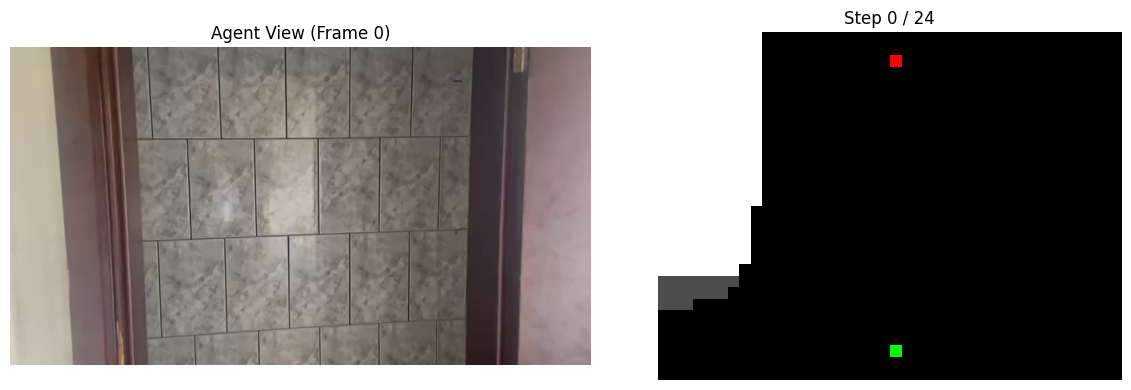

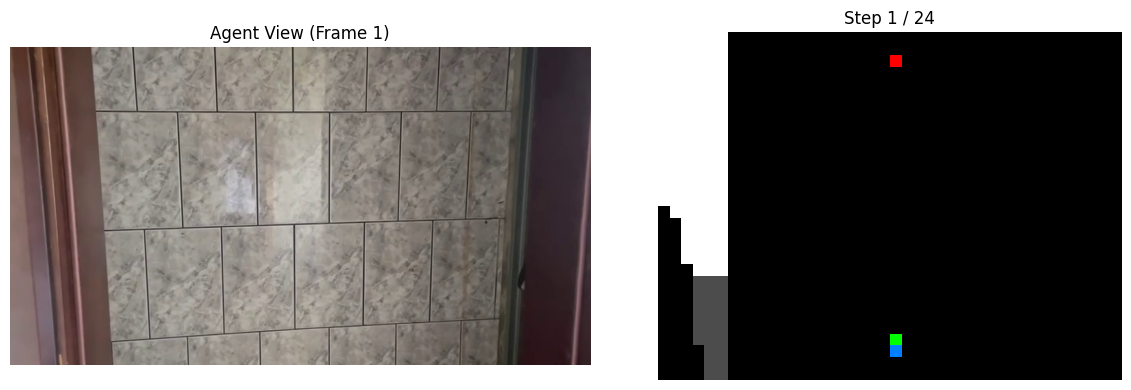

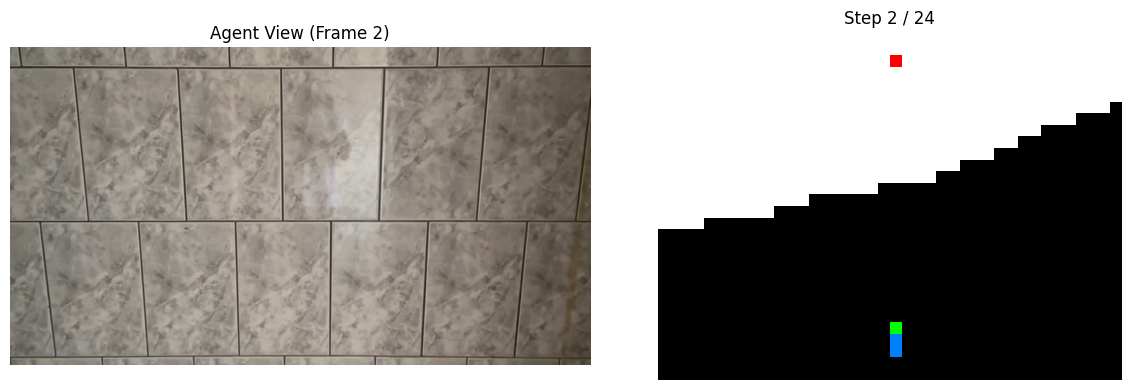

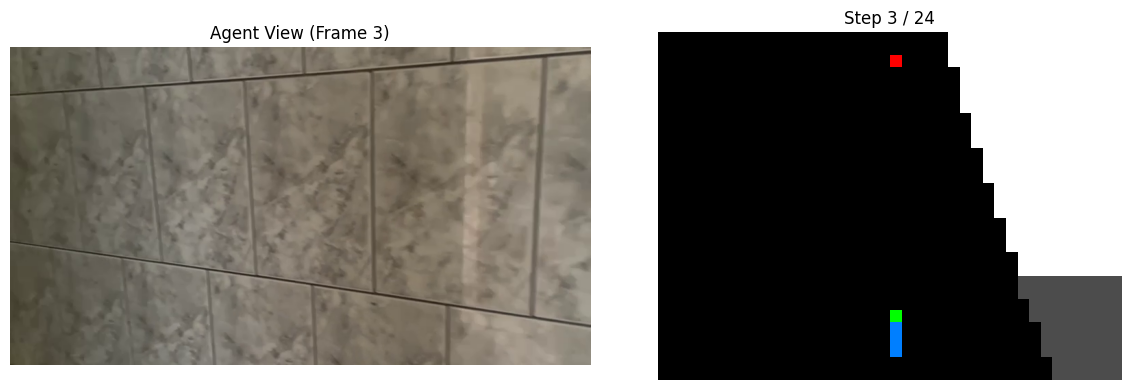

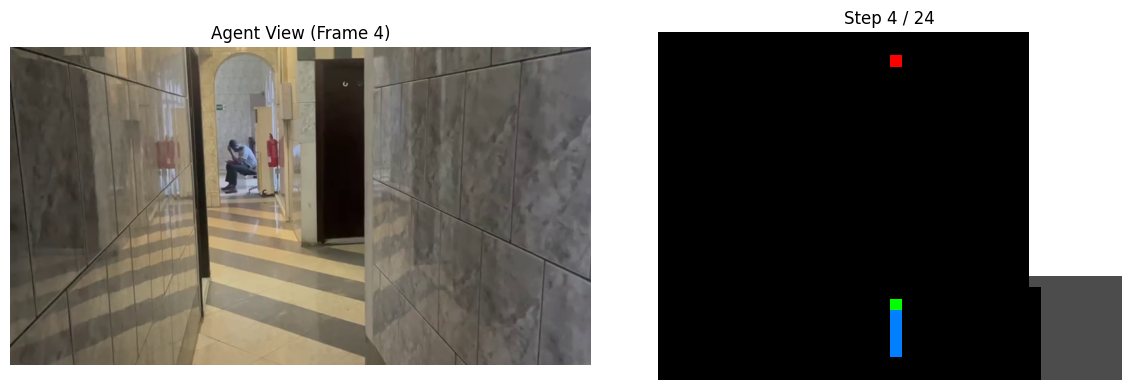

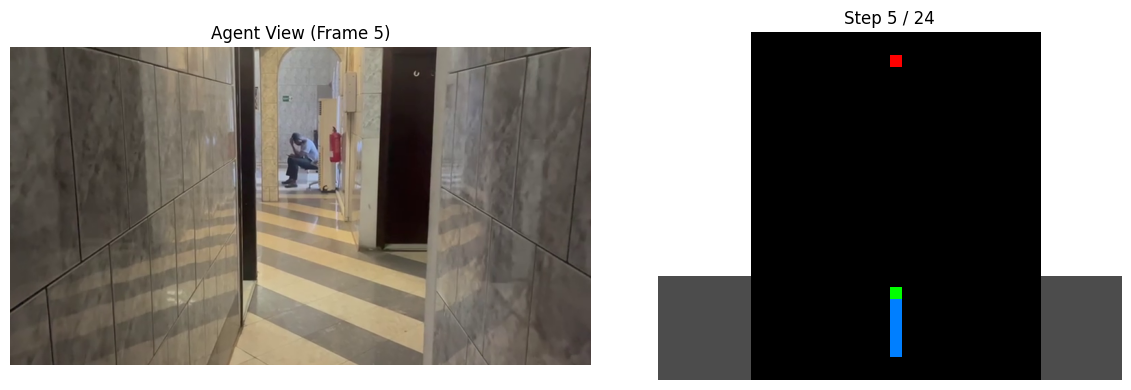

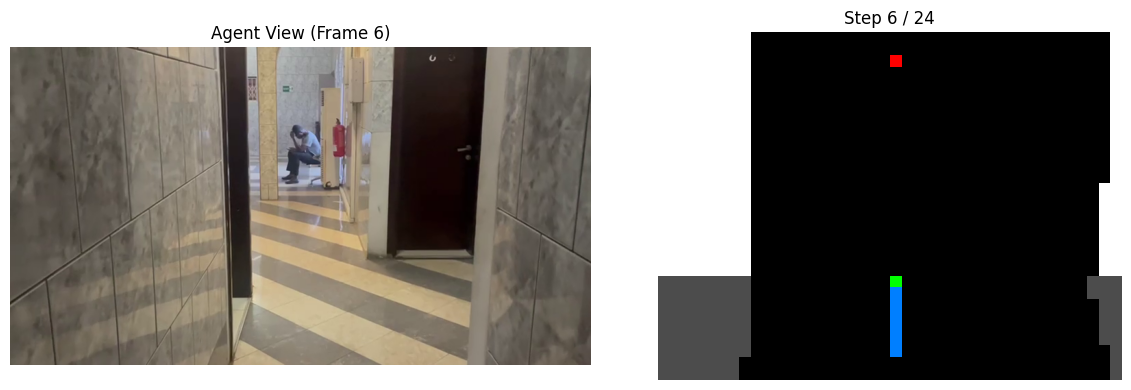

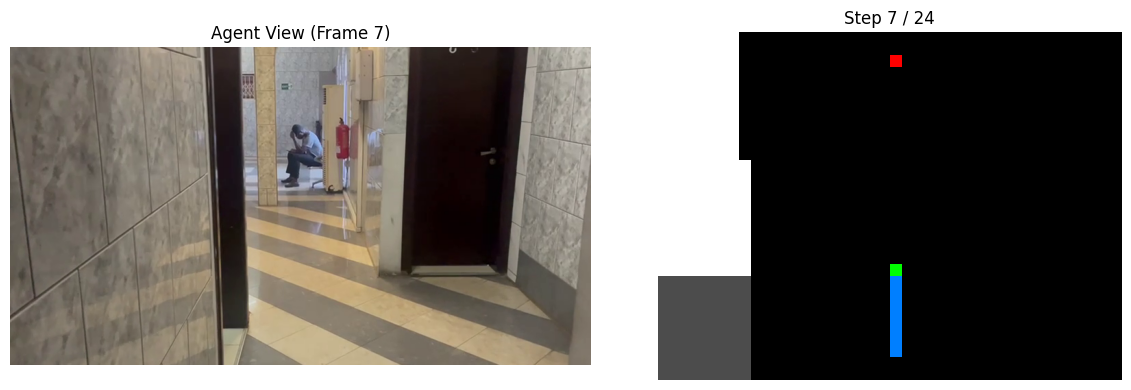

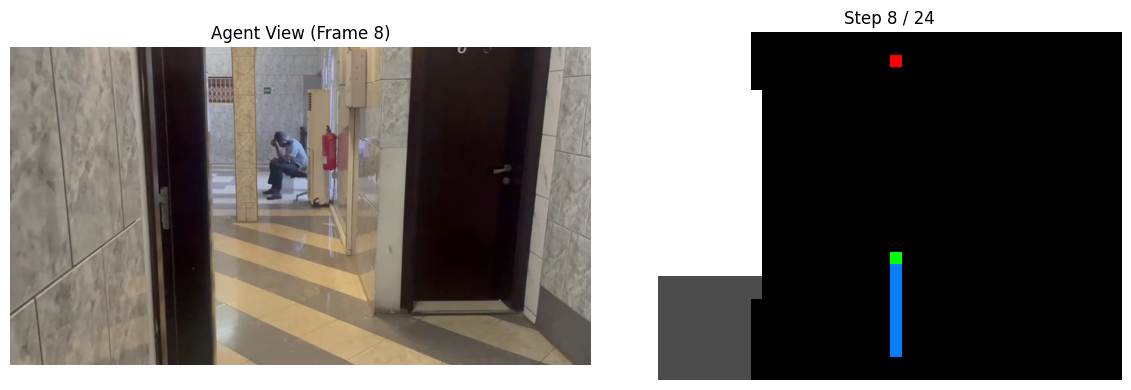

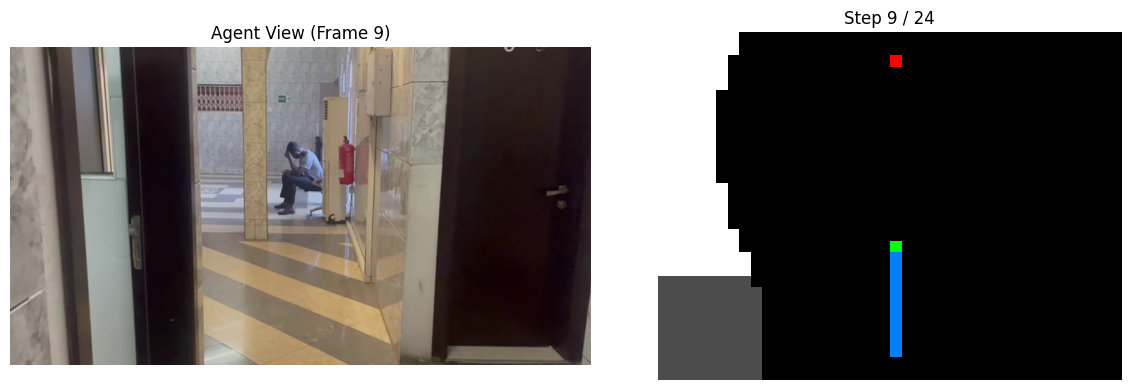

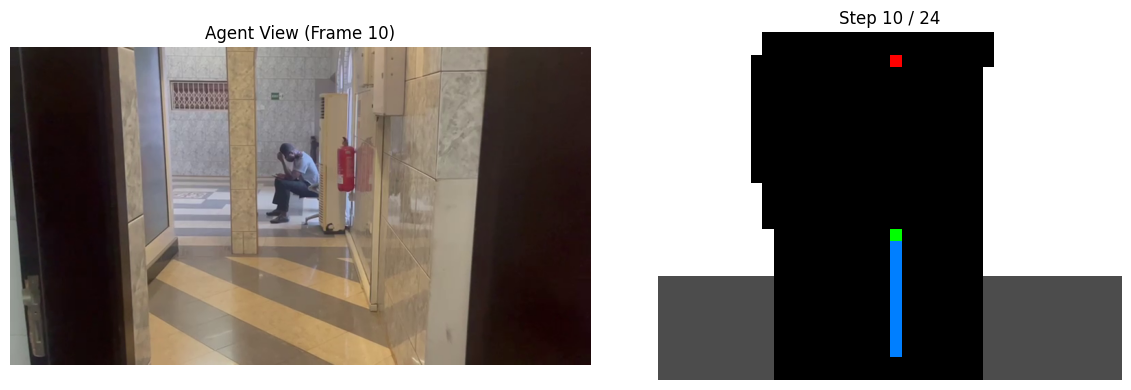

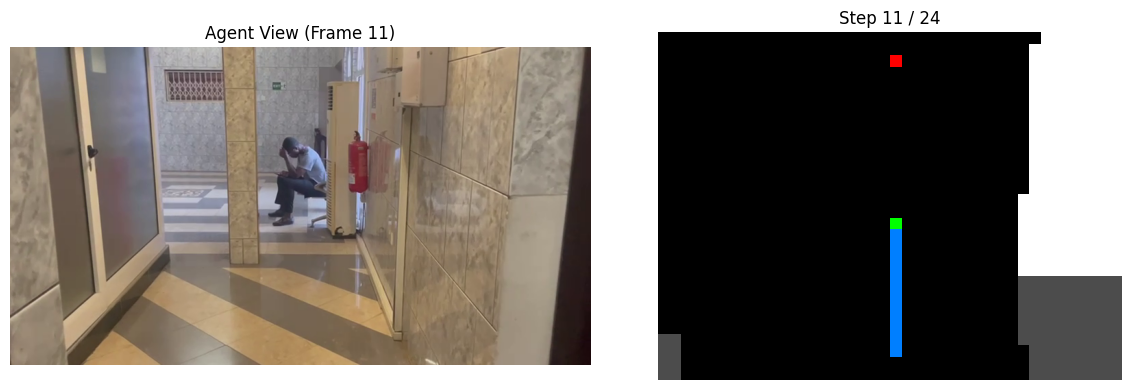

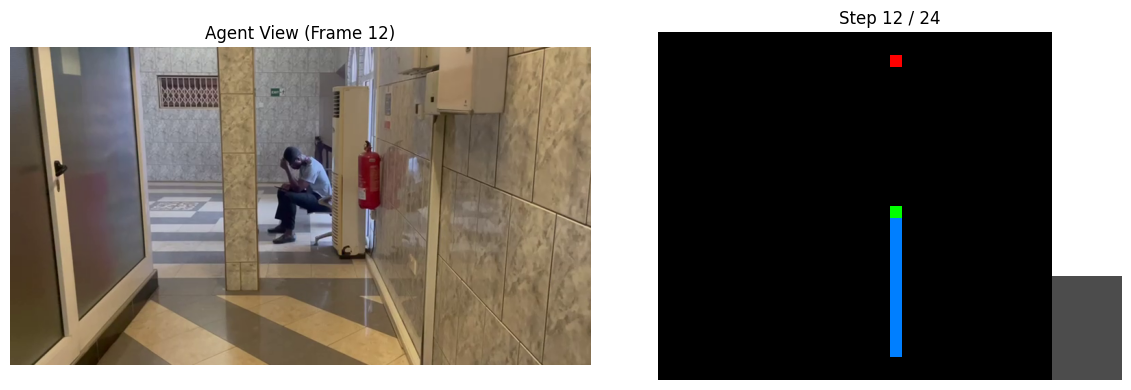

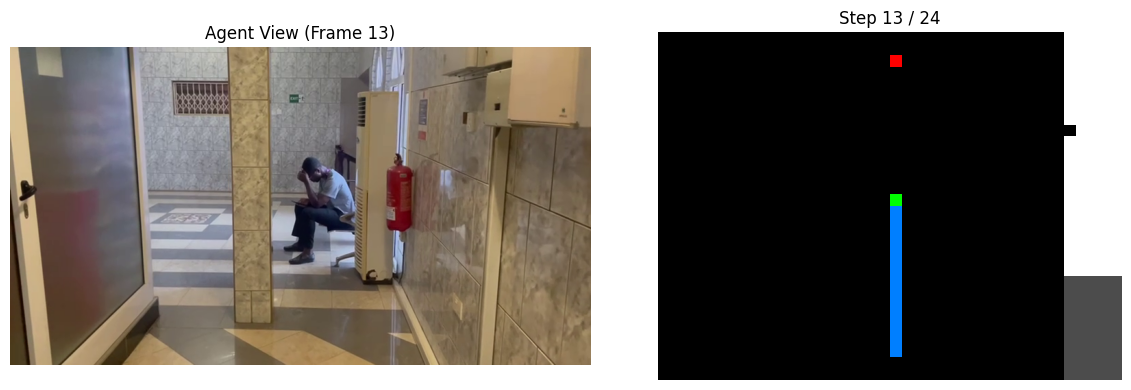

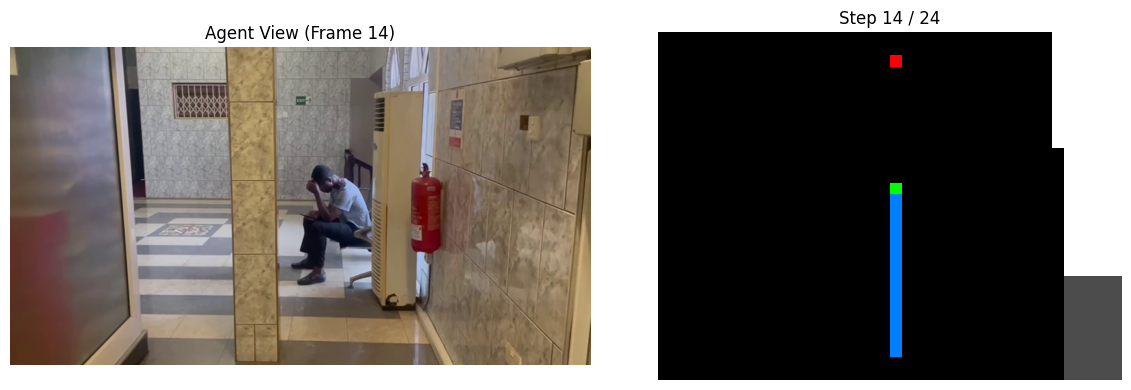

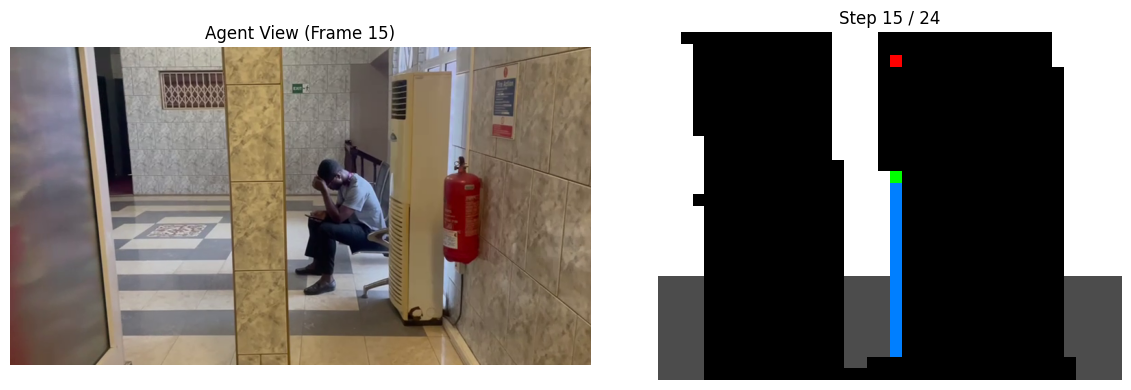

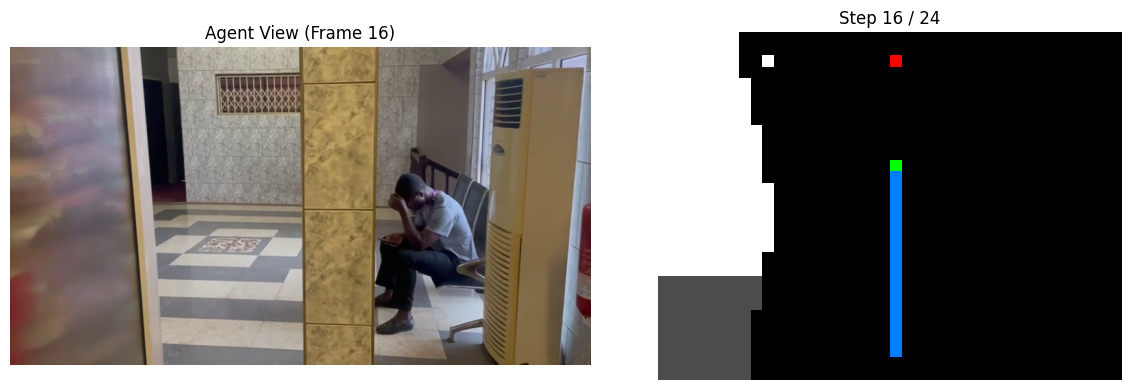

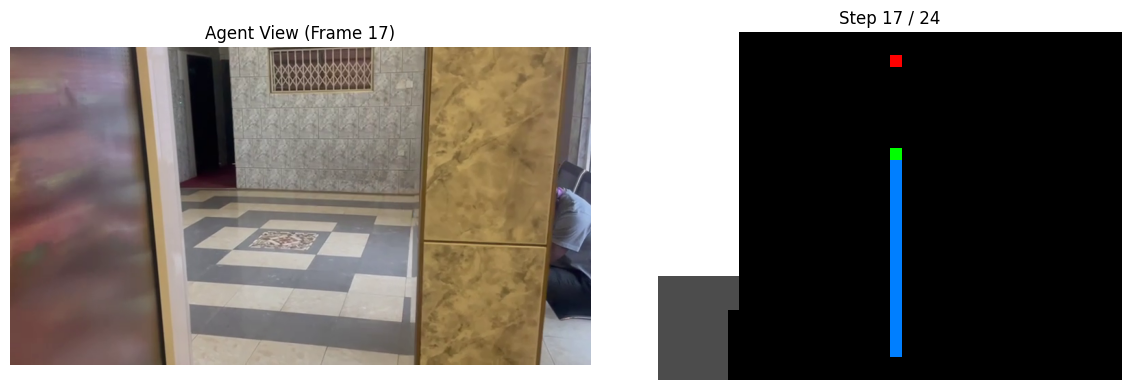

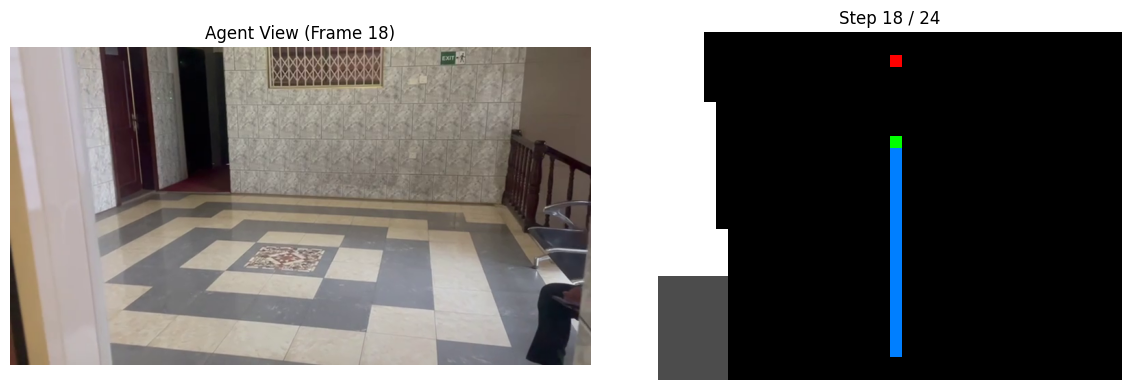

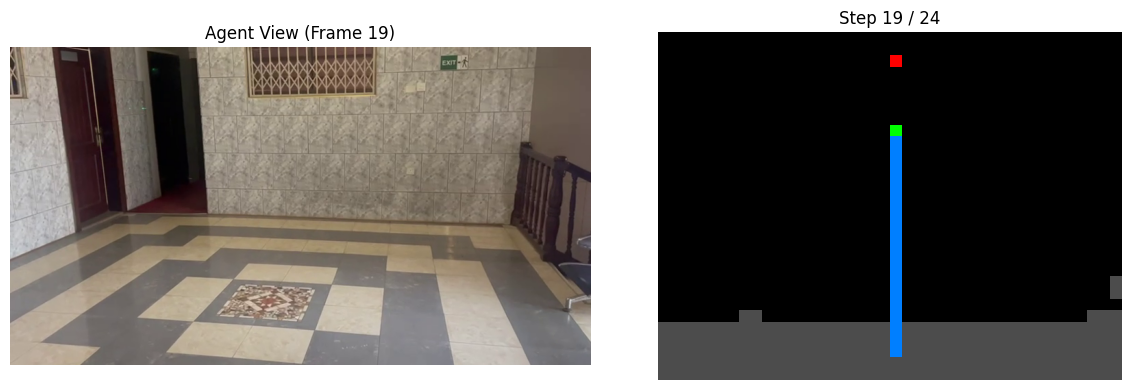

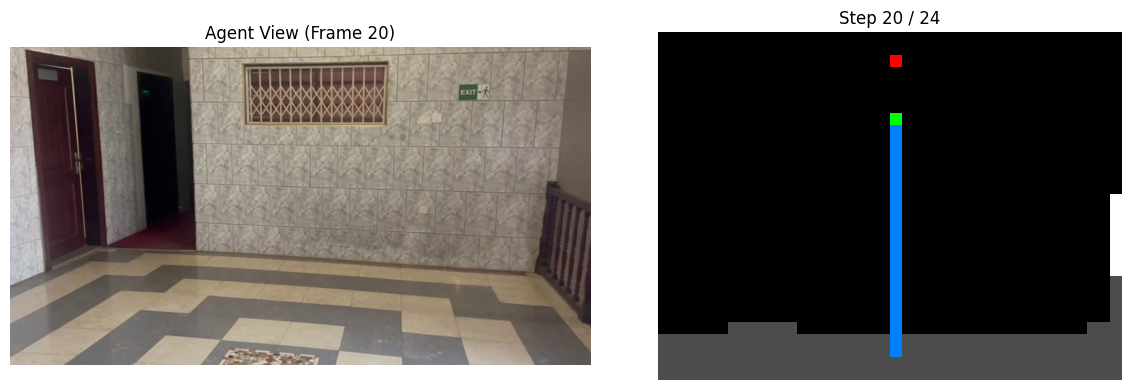

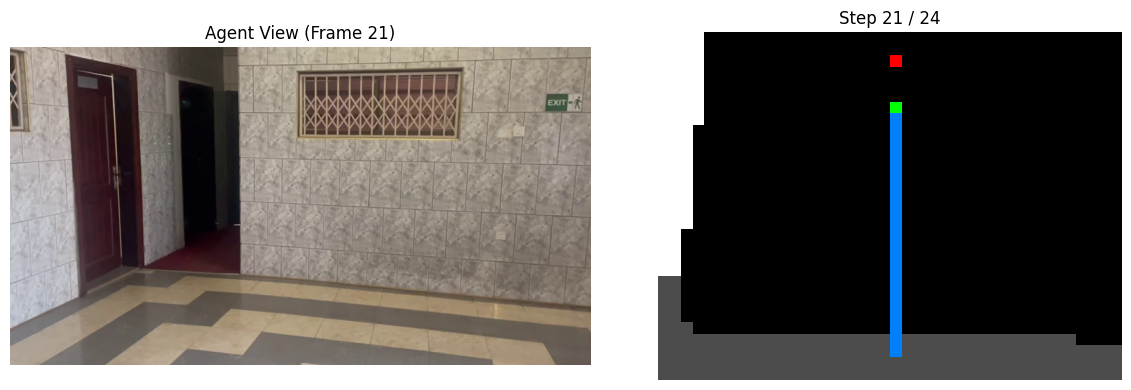

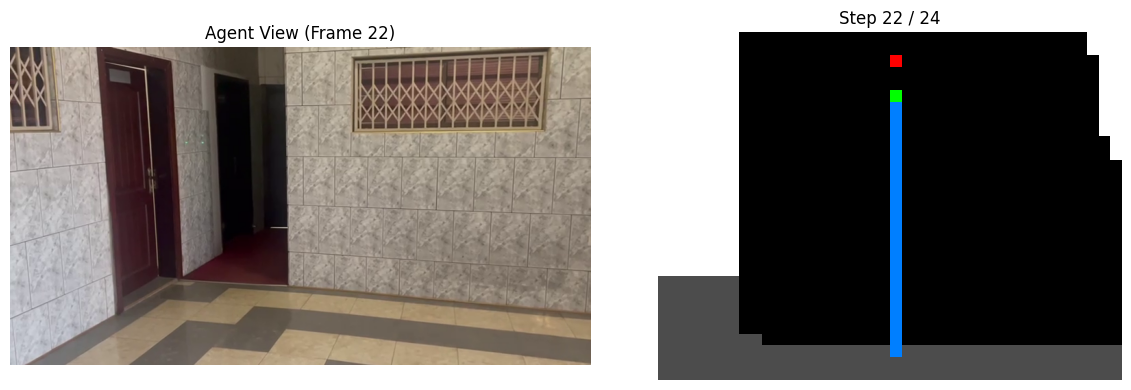

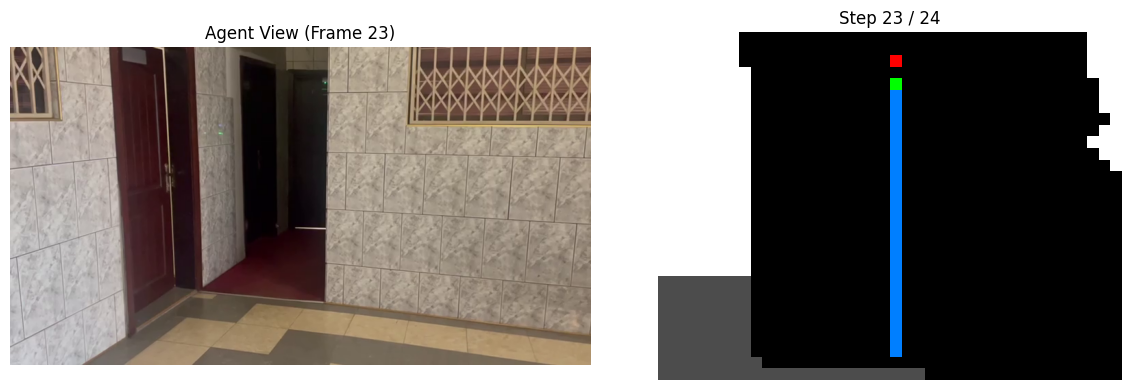

In [6]:

import time
def evaluate_agent(model, env, n_episodes=5):
    results = []
    for ep in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0.0
        steps = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            action = int(action)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1

        reached_goal = np.linalg.norm(env.agent_pos - env.goal_pos) < 3
        results.append({
            'episode': ep + 1,
            'reward': total_reward,
            'steps': steps,
            'trajectory': env.trajectory.copy(),
            'success': reached_goal
        })
        print(f"Episode {ep + 1}: {'SUCCESS' if reached_goal else 'FAILED'} | "
              f"Reward: {total_reward:.1f} | Steps: {steps}")

    return results


# Run evaluation
results = evaluate_agent(model, env, n_episodes=5)
best_result = max(results, key=lambda x: x['reward'])
print(f"Best Episode: #{best_result['episode']} | "
      f"Reward: {best_result['reward']:.1f} | Success: {best_result['success']}")

# Visualizations
def visualize_best_trajectory(env, best_result):
    print("Replaying best trajectory...")
    trajectory = best_result['trajectory']

    for step, pos in enumerate(trajectory):
        env.agent_pos = pos
        env.current_frame = min(step, env.max_frames - 1)
        env.current_step = step

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.imshow(cv2.cvtColor(env.frames[env.current_frame], cv2.COLOR_BGR2RGB))
        ax1.set_title(f"Agent View (Frame {env.current_frame})")
        ax1.axis("off")

        grid_viz = np.stack([env.occupancy_grids[env.current_frame]] * 3, axis=-1)
        for p in trajectory[:step]:
            grid_viz[p[0], p[1]] = [0, 0.5, 1]  # path trail
        grid_viz[pos[0], pos[1]] = [0, 1, 0]    # current agent position
        grid_viz[env.goal_pos[0], env.goal_pos[1]] = [1, 0, 0]  # goal

        ax2.imshow(grid_viz)
        ax2.set_title(f"Step {step} / {len(trajectory)}")
        ax2.axis("off")
        plt.tight_layout()
        plt.show()

        time.sleep(0.3)


# Replay the best episode visually
visualize_best_trajectory(env, best_result)
